In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
# Setup models to use and needed parameters for model selection
testSize = 0.25 #percentage of total set
k = 3 # for K-fold cross-validation
GBC = GradientBoostingClassifier()
RFC = RandomForestClassifier()
DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier()
models = [('Logistic regression',linear,RFE(linear)),
          ('Gradient Boosting', GBC, SelectFromModel(GBC)),
          ('Random Forests',RFC,SelectFromModel(RFC)),
          ('Decision tree',DTC,SelectFromModel(DTC)),
          ('Adaboost',ABC,SelectFromModel(ABC))]

In [77]:
# load the data
X = pd.read_csv("../binary/X.csv",header=None).values
y = pd.read_csv("../binary/y.csv",header=None,squeeze=True).values
waveLengths = pd.read_csv("../binary/Wavelength.csv",header=None)
X_toClassify = pd.read_csv("../binary/XToClassify.csv",header=None).values

# Put aside data for testing at the end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)


# Do some standard normalisation
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_toClassify = scaler.transform(X_toClassify)


In [78]:
# Get a baseline accruaccy
linear = LogisticRegression()
linear_selector = RFE(linear)
linear.fit(X_train,y_train)
f1_score(linear.predict(X_train),y_train)

1.0

In [79]:
# Setup a dataframe to contain the results
results = pd.DataFrame(columns=['Algorithm',
                                'Mean score',
                                'Total operation time on full feature set',
                                'Number of important features',
                                "Mean score on reduced feature set",
                                "Total operation time on reduced feature set"])

# Loop over the models and test their performance using cross validation and the f1 score
for name, model, selector in models:
    scores = cross_validate(model,X_train,y_train,cv=k,scoring='f1')
    
    # Can we do just as well with fewer features?
    selector.fit(X_train,y_train)
    X_reduced = selector.transform(X_train)
    scores_reduced = cross_validate(model,X_reduced,y_train,cv=k,scoring='f1')

    results.loc[len(results)] = pd.Series({
        'Algorithm' : name,
        "Mean score":scores['test_score'].mean(),
        "Total operation time on full feature set" : sum(scores['fit_time'])+sum(scores['score_time']),
        "Number of important features":sum(selector.get_support()),
        "Mean score on reduced feature set":scores_reduced['test_score'].mean(),
        "Total operation time on reduced feature set" : sum(scores_reduced['fit_time'])+sum(scores_reduced['score_time'])                                                                                                                                                    
    })


# calculate the 'rating' to determine the best model. Based on accuracy and operation time. Higher is better 
results['Rating'] = results['Mean score on reduced feature set'] /results['Total operation time on reduced feature set']
results.sort_values('Rating',ascending=False,inplace=True)
bestModelRecord = results.iloc[0]
results

,Algorithm,Mean score,Total operation time on full feature set,Number of important features,Mean score on reduced feature set,Total operation time on reduced feature set,Rating
3,Decision tree,1.0,0.024034,1,1.0,0.002827,353.770580
4,Adaboost,1.0,0.028514,1,1.0,0.006947,143.951127
0,Logistic regression,1.0,0.048361,460,1.0,0.018355,54.481386
2,Random Forests,1.0,0.051157,10,1.0,0.045595,21.932377
1,Gradient Boosting,1.0,0.535309,72,1.0,0.113994,8.772401


In [80]:
# Find the best model
for name,model,selector in models:
    if name == bestModelRecord['Algorithm']:
        bestModel = model
        bestSelector = selector
        
# Train the best model on the reduced feature set and report the accuracy
bestModel.fit(bestSelector.fit_transform(X_train,y_train),y_train)
f1_score(bestModel.predict(bestSelector.transform(X_test)),y_test)

1.0

In [81]:
# Use trained model to predict and store the results of the samples to classify
# Note that X_toClassify was already normalised
pd.DataFrame(bestModel.predict(bestSelector.transform(X_toClassify))).to_csv("../binary/PredictedClasses.csv",index=False)

In [85]:
bestFeatures = bestSelector.get_support()
df = pd.concat([pd.DataFrame(X[:,bestFeatures],columns=list(waveLengths[bestFeatures].values)),pd.DataFrame(y,columns=["label"])],axis=1)
df.head()

(703.76,)    5.36
label        0.00
Name: 1, dtype: float64

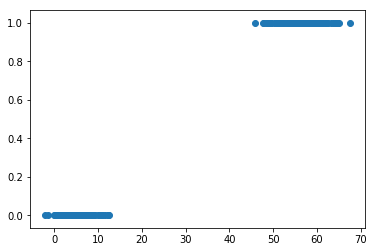

In [94]:
plt.scatter(x=df.iloc[:,0],y=df.iloc[:,1])
plt.show()